# import

In [1]:
import sys
sys.path.append('../')
from my_library.library import *
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from my_library.funcs import *
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt



# path win

In [40]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'
load_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles'
save_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/pickles'

# funcs

In [11]:
def return_corr(df):
    x = df['daw_close'].values
    y = df['close'].values
    corr = np.corrcoef(x,y)
    return corr

def split_df(df,start_year,end_year,start_month=1,end_month=12):
    df = df[df.index.year<=end_year]
    df = df[df.index.year>=start_year]
    df = df[df.index.month<=end_month]
    if start_month>0:
        df = df[df.index.month>=start_month]
    return df

def make_value_list(lx,start_year,end_year,path_tpx,path_daw,alpha=0.34,width=20,stride=10,start_month=1,end_month=12):

    lc_dummy = LearnClustering(width=width)
    df_con = lc_dummy.make_df_con(path_tpx,path_daw)
    
    df_con = split_df(df_con,start_year,end_year,start_month,end_month)
    
    x_,z_ = lc_dummy.make_x_data(df_con['close'],stride=stride,test_rate=1.0,width=width)
    length = len(z_)
    value_list = []

    for i in range(length):
        for strategy in ['normal','reverse']:
            try:
                xl = XGBSimulation2(lx,alpha=alpha)
                xl.simulate(path_tpx,path_daw,strategy=strategy,is_validate=True,start_year=start_year,end_year=end_year,df_=z_[i])
                
                trade_log =  xl.trade_log
                total_profit = trade_log['total_profit'].values[0]
                stock_wave = z_[i]
                vt = ValueTable(strategy,alpha,total_profit,trade_log,stock_wave)
                value_list.append(vt)
                
            except Exception as e:
                print(e)
                continue

    return value_list

def make_value_lx_dict(width=20,stride=5,path_=path_tpx):
    lx_dict = {}
    value_dict = {}


    lx_dummy = LearnXGB(num_class=3)
    x_train,y_train,_,_= lx_dummy.make_xgb_data(path_,path_daw,test_rate=1.0)
    _,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_,path_daw,test_rate=0.9)

    limit_year = 2015
    x_train_ = split_df(x_train,2015,limit_year)
    y_train_ = y_train[:len(x_train_)]
    lx = LearnXGB(num_class=3)
    lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)
    lx_dict[str(limit_year)] = lx

    for year in range(limit_year+1,2022):
        start_year = 2015
        end_year = year

        x_train_ = split_df(x_train,start_year,end_year)
        y_train_ = y_train[:len(x_train_)]
        
        
        lx = LearnXGB(num_class=3)
        lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)

        last_key = next(reversed(lx_dict),None)
        value_list = make_value_list(lx_dict[last_key],year,year,path_,path_daw,width=width,stride=stride)
        value_dict[str(year)] = value_list
        
        lx_dict[str(year)] = lx
    
    return value_dict,lx_dict
        
def return_clx(Value_list):
    Value_good = sorted(Value_list,key=lambda x :x[2],reverse=True)
    Value_bad = sorted(Value_list,key=lambda x :x[2],reverse=False)
    ng = []
    rg = []
    nb = []
    rb = []
    
    # 1sigam = 外れ値 として処理する
    prf_list=[]
    for vg in Value_good:
        total_profit = vg.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for idx,v in enumerate(Value_good):
        if v.total_profit<=0:break
        # if np.abs(st_prf[idx]) >=1:continue    

        df = v.stock_wave
        strategy = v.strategy
        # print(df)
        # break
        if strategy=="normal":
            ng.append(standarize(df))
        else:
            rg.append(standarize(df))

    prf_list=[]
    for vb in Value_bad:
        total_profit = vb.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for v in Value_bad:
        if v.total_profit>=0 :break
        # if np.abs(st_prf[idx]) >=1:continue  
        
        df = v.stock_wave
        strategy = v.strategy

        if strategy=="normal":
            nb.append(standarize(df))
        else:
            rb.append(standarize(df))

    x_ng = make_easy_x(ng)
    x_nb = make_easy_x(nb)
    x_rg = make_easy_x(rg)
    x_rb = make_easy_x(rb)
    return x_ng,x_nb,x_rg,x_rb

def concat_list(key_list,value_dict):
    value_list = []
    for key in key_list:
        v_lis = value_dict[key]
        for v in v_lis:
            value_list.append(v)
    return value_list


def return_uds_dict(value_dict,lx_dict,width=20,stride=5\
    ,cut_off=6,order=4,path_=path_tpx,limit_year=2012):
    uds_dict = {}
    trade_dict = {}
    lx_dummy = LearnXGB(num_class=3)
    alpha = 0.34

    for year in range(limit_year,2022):
        # print(year)
        start_month=1
        end_month = 12
        start_year = year
        end_year = year
        value_list = value_dict[str(year-1)]
        lx_ = lx_dict[str(year-1)]
        x_ng,x_nb,x_rg,x_rb = return_clx(value_list)

        try:
            Ustrategies= return_uds(lx_,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=width,stride=stride,\
                cut_off=cut_off,order=order)
            """
            # Fstrategies をどんどん加算していく    
            # if len(uds_dict)>0:
            #     last_key = next(reversed(uds_dict),None)
            #     Fstrategies_old = uds_dict[last_key].Ustrategies
            #     Fstrategies = return_cumulative_fst(Fstrategies,Fstrategies_old)
            """
        except Exception as e:
            print(e)
            last_key = next(reversed(uds_dict),None)
            Ustrategies = uds_dict[last_key].Ustrategies
        
        uds = UpDownSimulation(lx_,Ustrategies,width=width,alpha=alpha)
        uds.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True,cut_off=cut_off,order=order)
        
        uds_dict[str(year)] = uds
        trade_dict[str(year)] = (uds.trade_log,uds.pr_log,uds.accuracy_df,uds.cnt_normal,uds.cnt_reverse)
    
    return uds_dict, trade_dict

def return_uds(lx,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=20,stride=10,cut_off=6,order=4):

    log_dict = {}
    cs_dict = {}
    ffs_dict = {}
    random_state=0
    alpha = 0.33
    n_cluster = 1
    Ustrategies = []

    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            # このタイミングでハイパスフィルタかける
            # make_spectrum 内の関数をいじる
            filtered_wave = butter_lowpass_filter(wave,cut_off,len(wave),order=order)
            strategy = strategy_list[j]
            us  = Fstrategy(strategy,alpha,filtered_wave)
            Ustrategies.append(us)

        j+=1

    return Ustrategies


def plot_profit(trade_dict,verbose=False):
    total_profit = 0
    mean_profit = 0
    mean_profit_rate = 0
    total_profit_rate = 0
    for idx,key in enumerate(trade_dict):
        print(key)
        print(trade_dict[key])
        td = trade_dict[key]
        total_profit += td['total_profit'].values[0]
        total_profit_rate += td['profit rate'].values[0]
        
    mean_profit = total_profit/(idx+1)
    mean_profit_rate = (total_profit_rate)/(idx+1)

    print('total profit :{0}'.format(total_profit))
    print('mean profit :{0}'.format(mean_profit))
    print('total profit rate :{0}'.format(total_profit_rate))
    print('mean profit rate : {0}'.format(mean_profit_rate))
    if verbose:
        return total_profit,mean_profit,total_profit_rate,mean_profit_rate
    else:
        return 0
    
    
def plot_var(pr_list_ts,pr_list,key):
    height1 = pr_list_ts.copy()
    height2 = pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2017,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='Golden and Dead')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='Proposed method')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("Rate of return (%)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_xticks(labels)

    plt.show()
    
def plot_cumulative_var(cumulative_pr_list_ts,cumulative_pr_list,key):
    height1 = cumulative_pr_list_ts.copy()
    height2 = cumulative_pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2012,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='Golden and Dead')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='Proposed method')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("Cumulative rate of return (%)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_xticks(labels)

    plt.show()
    
def get_gyosyu_df(path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu/'):
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace(path_gyosyu,'')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE

# class

In [12]:

class UpDownSimulation(Simulation):
    
    
    def __init__(self,lx,Ustrategies,width=20,alpha=0.34):
        super(UpDownSimulation,self).__init__()
        self.lx = lx 
        self.xgb_model = lx.model
        self.Ustrategies = Ustrategies
        self.width = width
        self.alpha = alpha
        self.ma_long = 25
        self.ma_short = 5
    
    
    def choose_strategy(self,wave,cut_off=6,order=4):
        filtered_wave = butter_lowpass_filter(wave,cut_off,len(wave),order=order)
        diff_wave = np.diff(filtered_wave)
        sum_diff = sum(diff_wave)
        strategy = 'none'

        # 右肩下がりの時
        if sum_diff<=0:
            strategy = 'stay'
    
        # 右肩上がりの時
        else:
            normal_wave = self.Ustrategies[0].spectrum
            reverse_wave = self.Ustrategies[2].spectrum
            
            n_cos = cos_sim(normal_wave,wave)
            r_cos = cos_sim(reverse_wave,wave)
            if n_cos>=r_cos:
                strategy = 'normal'
            else:
                strategy = 'reverse'
                
        return strategy
    
    def make_x_dict(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        x_dict = {}
        lc = LearnClustering()
        x_, z_ = lc.make_x_data(df_con['close'],stride=1,test_rate=1.0,width=self.width)
        length = len(z_)

        for i in range(length):
            time_ = z_[i].index[-1]
            x_dict[time_] = standarize(x_[i])
        
        return x_dict
    

    def simulate(self, path_tpx, path_daw, is_validate=False,is_online=False,start_year=2021,end_year=2021,start_month=1,end_month=12,
        is_observed=False,cut_off=6,order=4,HOLD_DAY=20):

        x_check,y_check,y_,df_con,pl = self.simulate_routine(path_tpx, path_daw,start_year,end_year,start_month,end_month,'None',is_validate)
        self.x_check = x_check
        x_tmp,y_tmp,current_date,acc_df = self.set_for_online(x_check,y_)
        x_dict = self.make_x_dict(path_tpx,path_daw)
        length = len(x_check)
        prf_list = []
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        self.predict_proba = predict_proba
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        hold_day = 0
        trigger_count = 0
        trade_count = 0
        total_eval_price = 0
        cant_buy = 0
        buy_count = 0
        sell_count = 0
        # for debug
        self.strategies = []
        self.spe_list = []
        self.cnt_normal = 0
        self.cnt_reverse = 0
        pre_trategy = 'none'
        self.stay_detect_count = 0
        
        for i in range(length-1):
            is_trigger = False
            time_ = df_con.index[i]
            wave = x_dict[time_]

            if not is_bought:
                strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
                pre_strategy = strategy

            # 差分
            # if is_bought:
            #     strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
            #     if pre_strategy!='none' and (pre_strategy=='normal' or pre_strategy=='reverse') and strategy=='stay':
            #         is_trigger=True
            #         self.stay_detect_count += 1
                
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            tmp_date = x_tmp.index[i]   

            if is_online and current_date.month!=tmp_date.month:
                predict_proba, current_date = self.learn_online(x_tmp,y_tmp,x_check,current_date,tmp_date)


            if prob > self.alpha:
                if label == 0:
                    acc_df.iloc[i] = 0
                elif label == 1:  
                    acc_df.iloc[i] = 1
                else: #  label==2
                    acc_df.iloc[i] = 2

            if strategy=='reverse':
                self.strategies.append(-1)
                is_buy  = (label==0 and prob>self.alpha)
                is_sell = (label==2 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] > df_con['close'].loc[x_check.index[i]]))
                if is_buy and is_bought: self.cnt_reverse += 1
            
            elif strategy=='normal':
                self.strategies.append(1)
                is_buy  = (label==2 and prob>self.alpha)
                is_sell = (label==0 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] < df_con['close'].loc[x_check.index[i]]))
                if is_buy and is_bought: self.cnt_normal += 1
            elif strategy=='stay' :
            
                self.strategies.append(0)
                is_buy = False
                is_sell =  False
                is_cant_buy = False

            
            if not is_bought:
                
                if is_cant_buy:
                    cant_buy += 1
                    continue
                elif is_buy:
                    index_buy, start_time, is_bought = self.buy(df_con,x_check,i)
                    buy_count += 1

            else:
                hold_day += 1
                
                if hold_day>=HOLD_DAY:
                    trigger_count+=1
                    is_trigger = True
                
                if is_sell or is_trigger:
                    prf, trade_count, is_bought = self.sell(df_con,x_check,prf,index_buy,prf_list,trade_count,pl,start_time,i,is_validate)
                    hold_day = 0
                    is_trigger = False
                    sell_count += 1
                else:
                    total_eval_price = self.hold(df_con,index_buy,total_eval_price,i)
                    
            
            self.is_bought = is_bought
                
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            if not is_validate:
                pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        self.acc_df = acc_df
        self.y_check = y_check
            
        
        # try:
        df = self.calc_acc(acc_df, y_check)
        self.accuracy_df = df
        log = self.return_trade_log(prf,trade_count,prf_array,cant_buy)
        self.trade_log = log
        
        
        if not is_validate:
            print(log)
            print("")
            print(df)
            print("")
            print("trigger_count :",trigger_count)
            # print("buy_count",buy_count)
            # print("sell_count",sell_count)
            pl.show()
            


# メモ

1. 業種の寄与率などキチンと考慮すべき
2. ログをちゃんととる

# load pickle

In [20]:
value_dict = load_pickle(save_pickle_path+'/value_dict_w20.pickle')
lx_dict = load_pickle(save_pickle_path+'/lx_dict_w2.pickle')

# make uds object

In [21]:
uds_dict,trade_dict = return_uds_dict(value_dict,lx_dict,width=20,stride=5\
    ,cut_off=6,order=4,path_=path_tpx,limit_year=2012)

# save pickle

In [41]:
# save_pickle(save_pickle_path+'/uds_dict.pickle',uds_dict)
# save_pickle(save_pickle_path+'/trade_dict.pickle',trade_dict)

In [66]:
pr_list = []
for i,key in enumerate(trade_dict):
    pr_list.append(trade_dict[key][0]['profit rate'].values[0])
    

In [68]:
sum(pr_list),np.std(pr_list)

(43.96000000000001, 5.272037936130581)

# ave wave

In [48]:
ave_wave = np.zeros(20)
ave_wave_dict = {}  

st = 0

for st in [0,1,2,3]:

    ave_wave = np.zeros(20)
    for idx,key in enumerate(uds_dict):
        # if key=='2017':break
        uds = uds_dict[key]
        wave = uds.Ustrategies[st].spectrum
        ave_wave += wave
        # break
    ave_wave_dict[st] = standarize(ave_wave)


[]

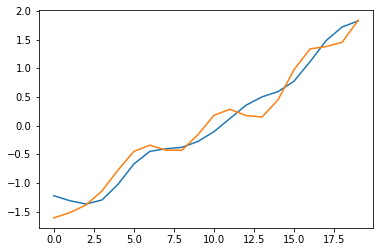

In [73]:
ax = plt.gca()
ax.plot(ave_wave_dict[0])
ax.plot(ave_wave_dict[2])
plt.plot()